# 5. Modelado y predicción

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df_impute.to_csv('Datos_procesados.csv',index=False)

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense
from tensorflow.keras import backend as K


def rmse(y_true, y_pred):
    """
    Calcula el error cuadrático medio (RMSE) entre las predicciones y los valores verdaderos.

    Args:
        y_true (tensor): Valores verdaderos.
        y_pred (tensor): Valores predichos.

    Returns:
        tensor: RMSE.
    """
    return K.sqrt(K.mean(K.square(y_pred - y_true)))


def split_dataframe(df, train_ratio=0.7, test_ratio=0.2):
    """
    Divide un DataFrame en conjuntos de entrenamiento, prueba y evaluación.

    Args:
        df (DataFrame): El DataFrame a dividir.
        train_ratio (float, optional): Proporción de datos para entrenamiento. Defaults to 0.7.
        test_ratio (float, optional): Proporción de datos para prueba. Defaults to 0.2.

    Returns:
        tuple: DataFrames de entrenamiento, prueba y evaluación.
    """
    total_size = len(df)  # Tamaño total del DataFrame
    train_size = int(total_size * train_ratio)  # Tamaño del conjunto de entrenamiento
    test_size = int(total_size * test_ratio)  # Tamaño del conjunto de prueba
    eval_size = total_size - train_size - test_size  # Tamaño del conjunto de evaluación

    df_train = df.iloc[:train_size]  # Conjunto de entrenamiento
    df_test = df.iloc[train_size:train_size + test_size]  # Conjunto de prueba
    df_eval = df.iloc[train_size + test_size:]  # Conjunto de evaluación

    return df_train, df_test, df_eval


def scale_datasets(train_df, test_df, eval_df):
    """
    Escala los conjuntos de datos de entrenamiento, prueba y evaluación.

    Args:
        train_df (DataFrame): DataFrame de entrenamiento.
        test_df (DataFrame): DataFrame de prueba.
        eval_df (DataFrame): DataFrame de evaluación.

    Returns:
        tuple: DataFrames escalados de entrenamiento, prueba y evaluación, y diccionario de escaladores.
    """
    scalers = {}  # Diccionario para almacenar los escaladores
    scaled_train_df = train_df.copy()  # Copia del DataFrame de entrenamiento
    scaled_test_df = test_df.copy()  # Copia del DataFrame de prueba
    scaled_eval_df = eval_df.copy()  # Copia del DataFrame de evaluación

    for column in train_df.columns:
        scaler = MinMaxScaler()  # Crear un escalador MinMax para cada columna
        scaled_train_df[column] = scaler.fit_transform(train_df[[column]])  # Ajustar y transformar los datos de entrenamiento
        scaled_test_df[column] = scaler.transform(test_df[[column]])  # Transformar los datos de prueba
        scaled_eval_df[column] = scaler.transform(eval_df[[column]])  # Transformar los datos de evaluación
        scalers[column] = scaler  # Guardar el escalador para cada columna

    return scaled_train_df, scaled_test_df, scaled_eval_df, scalers

def create_sequences(data, input_columns, output_columns, time_steps, future_steps=1):
    """
    Crea secuencias de datos para modelado de series temporales.

    Args:
        data (DataFrame): DataFrame con los datos.
        input_columns (list): Columnas de entrada.
        output_columns (list): Columnas de salida.
        time_steps (int): Número de pasos de tiempo para las secuencias de entrada.
        future_steps (int, optional): Número de pasos de tiempo futuros para las secuencias de salida. Defaults to 1.

    Returns:
        tuple: Arrays de entrada y salida para el modelo.
    """
    X, y = [], []  # Listas para almacenar las secuencias de entrada y salida
    data_array = data.values  # Convertir el DataFrame a un array numpy

    input_indices = data.columns.get_indexer(input_columns)  # Índices de las columnas de entrada
    output_indices = data.columns.get_indexer(output_columns)  # Índices de las columnas de salida

    for i in range(len(data) - time_steps - future_steps + 1):
        X.append(data_array[i:i + time_steps, input_indices])  # Crear secuencia de entrada
        y.append(data_array[i + time_steps:i + time_steps + future_steps, output_indices].flatten())  # Crear secuencia de salida

    return np.array(X), np.array(y)

def create_simple_rnn_model(input_shape, output_size, future_steps, rnn_units=50, hidden_units=50, output_activation='linear'):
    """
    Crea un modelo SimpleRNN.

    Args:
        input_shape (tuple): Forma de las secuencias de entrada.
        output_size (int): Tamaño de la salida.
        future_steps (int): Número de pasos de tiempo futuros.
        rnn_units (int, optional): Unidades de la capa RNN. Defaults to 50.
        hidden_units (int, optional): Unidades de la capa oculta. Defaults to 50.
        output_activation (str, optional): Activación de la capa de salida. Defaults to 'linear'.

    Returns:
        model: Modelo compilado de SimpleRNN.
    """
    model = Sequential()  # Crear un modelo secuencial
    model.add(SimpleRNN(rnn_units, input_shape=input_shape, return_sequences=False))  # Añadir capa SimpleRNN
    model.add(Dense(hidden_units, activation='relu'))  # Añadir capa oculta densa
    model.add(Dense(output_size * future_steps, activation=output_activation))  # Añadir capa de salida
    model.compile(optimizer='adam', loss='mse', metrics=[rmse])  # Compilar el modelo
    return model

def create_lstm_model(input_shape, output_size, future_steps, lstm_units=50, hidden_units=50, output_activation='linear'):
    """
    Crea un modelo LSTM.

    Args:
        input_shape (tuple): Forma de las secuencias de entrada.
        output_size (int): Tamaño de la salida.
        future_steps (int): Número de pasos de tiempo futuros.
        lstm_units (int, optional): Unidades de la capa LSTM. Defaults to 50.
        hidden_units (int, optional): Unidades de la capa oculta. Defaults to 50.
        output_activation (str, optional): Activación de la capa de salida. Defaults to 'linear'.

    Returns:
        model: Modelo compilado de LSTM.
    """
    model = Sequential()  # Crear un modelo secuencial
    model.add(LSTM(lstm_units, input_shape=input_shape, return_sequences=False))  # Añadir capa LSTM
    model.add(Dense(hidden_units, activation='relu'))  # Añadir capa oculta densa
    model.add(Dense(output_size * future_steps, activation=output_activation))  # Añadir capa de salida
    model.compile(optimizer='adam', loss='mse', metrics=[rmse])  # Compilar el modelo
    return model


def create_gru_model(input_shape, output_size, future_steps, gru_units=50, hidden_units=50, output_activation='linear'):
    """
    Crea un modelo GRU.

    Args:
        input_shape (tuple): Forma de las secuencias de entrada.
        output_size (int): Tamaño de la salida.
        future_steps (int): Número de pasos de tiempo futuros.
        gru_units (int, optional): Unidades de la capa GRU. Defaults to 50.
        hidden_units (int, optional): Unidades de la capa oculta. Defaults to 50.
        output_activation (str, optional): Activación de la capa de salida. Defaults to 'linear'.

    Returns:
        model: Modelo compilado de GRU.
    """
    model = Sequential()  # Crear un modelo secuencial
    model.add(GRU(gru_units, input_shape=input_shape, return_sequences=False))  # Añadir capa GRU
    model.add(Dense(hidden_units, activation='relu'))  # Añadir capa oculta densa
    model.add(Dense(output_size * future_steps, activation=output_activation))  # Añadir capa de salida
    model.compile(optimizer='adam', loss='mse', metrics=[rmse])  # Compilar el modelo
    return model

def plot_final_prediction(model, X, y, scalers, output_columns, future_steps, title):
    """
    Grafica las predicciones finales del modelo en comparación con los valores reales.

    Args:
        model (Sequential): Modelo entrenado.
        X (ndarray): Datos de entrada.
        y (ndarray): Valores reales.
        scalers (dict): Diccionario de escaladores para reescalar los datos.
        output_columns (list): Columnas de salida.
        future_steps (int): Número de pasos de tiempo futuros.
        title (str): Título de la gráfica.
    """
    predictions = model.predict(X).reshape(-1, future_steps, len(output_columns))  # Realizar predicciones y darles forma

    # Reescalar las predicciones y los valores reales
    y_rescaled = np.zeros((y.shape[0], len(output_columns)))
    predictions_rescaled = np.zeros((predictions.shape[0], future_steps, len(output_columns)))

    for i, column in enumerate(output_columns):
        y_rescaled[:, i] = scalers[column].inverse_transform(y[:, i].reshape(-1, 1)).reshape(-1)  # Reescalar valores reales
        for step in range(future_steps):
            predictions_rescaled[:, step, i] = scalers[column].inverse_transform(predictions[:, step, i].reshape(-1, 1)).reshape(-1)  # Reescalar predicciones

    plt.figure(figsize=(14, 5))  # Crear figura
    for i in range(len(output_columns)):
        plt.plot(y_rescaled[:, i], label='Valor Real')  # Graficar valores reales
        plt.plot(predictions_rescaled[:, -1, i], label='Predicción')  # Graficar predicciones
        plt.title(f'{title} - Variable {output_columns[i]}')  # Añadir título
        plt.legend()

    plt.tight_layout()
    plt.show()

# Función para graficar los errores finales del modelo
def plot_final_errors(model, X, y, scalers, output_columns, future_steps, title):
    """
    Grafica los errores finales del modelo en comparación con los valores reales.

    Args:
        model (Sequential): Modelo entrenado.
        X (ndarray): Datos de entrada.
        y (ndarray): Valores reales.
        scalers (dict): Diccionario de escaladores para reescalar los datos.
        output_columns (list): Columnas de salida.
        future_steps (int): Número de pasos de tiempo futuros.
        title (str): Título de la gráfica.
    """
    predictions = model.predict(X).reshape(-1, future_steps, len(output_columns))  # Realizar predicciones y darles forma

    # Reescalar las predicciones y los valores reales
    y_rescaled = np.zeros((y.shape[0], len(output_columns)))
    predictions_rescaled = np.zeros((predictions.shape[0], future_steps, len(output_columns)))

    for i, column in enumerate(output_columns):
        y_rescaled[:, i] = scalers[column].inverse_transform(y[:, i].reshape(-1, 1)).reshape(-1)  # Reescalar valores reales
        for step in range(future_steps):
            predictions_rescaled[:, step, i] = scalers[column].inverse_transform(predictions[:, step, i].reshape(-1, 1)).reshape(-1)  # Reescalar predicciones

    errors_rescaled = y_rescaled - predictions_rescaled[:, -1, :]  # Calcular errores reescalados

    plt.figure(figsize=(14, 5))  # Crear figura
    for i in range(len(output_columns)):
        plt.plot(errors_rescaled[:, i], label='Error')  # Graficar errores
        plt.title(f'{title} - Error Variable {output_columns[i]}')  # Añadir título
        plt.legend()

    plt.tight_layout()
    plt.show()

def plot_training_history(history, title='Historial de Entrenamiento'):
    """
    Grafica el historial de entrenamiento del modelo.

    Args:
        history (History): Historial de entrenamiento del modelo.
        title (str, optional): Título de la gráfica. Defaults to 'Historial de Entrenamiento'.
    """
    # Extraer la información del historial
    history_dict = history.history

    # Crear una figura
    plt.figure(figsize=(14, 5))

    # Graficar la pérdida (loss)
    plt.subplot(1, 2, 1)
    plt.plot(history_dict['loss'], label='Pérdida en Entrenamiento')
    if 'val_loss' in history_dict:
        plt.plot(history_dict['val_loss'], label='Pérdida en Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.title('Pérdida durante el Entrenamiento')
    plt.legend()

    # Graficar la métrica RMSE
    plt.subplot(1, 2, 2)
    plt.plot(history_dict['rmse'], label='RMSE en Entrenamiento')
    if 'val_rmse' in history_dict:
        plt.plot(history_dict['val_rmse'], label='RMSE en Validación')
    plt.xlabel('Épocas')
    plt.ylabel('RMSE')
    plt.title('RMSE durante el Entrenamiento')
    plt.legend()

    # Ajustar el diseño y mostrar la gráfica
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


## Univariado multi-step

In [16]:
# Paso 1: Leer el archivo CSV
file_path = 'Datos_procesados.csv'  # Reemplaza con la ruta a tu archivo
df = pd.read_csv(file_path)

df_train, df_test, df_eval = split_dataframe(df, train_ratio=0.7, test_ratio=0.2)

print(f"Tamaño de datos de entrenamiento: {len(df_train)}")
print(f"Tamaño de datos de prueba: {len(df_test)}")
print(f"Tamaño de datos de evaluación: {len(df_eval)}")


Tamaño de datos de entrenamiento: 851
Tamaño de datos de prueba: 243
Tamaño de datos de evaluación: 123


In [49]:
scaled_train_df, scaled_test_df, scaled_eval_df, scalers = scale_datasets(df_train, df_test, df_eval)

time_steps = 30
future_steps = 8
#input_columns = ['CE-CO','CE-PM10','julian_day','hour']  # Nombres de las columnas de entrada en el DataFrame escalado
input_columns = ['NO']  # Nombres de las columnas de entrada en el DataFrame escalado
output_columns = ['NO']  # Nombres de las columnas de salida en el DataFrame escalado


X_train, y_train = create_sequences(scaled_train_df, input_columns, output_columns, time_steps, future_steps)
X_test, y_test = create_sequences(scaled_test_df, input_columns, output_columns, time_steps, future_steps)
X_eval, y_eval = create_sequences(scaled_eval_df, input_columns, output_columns, time_steps, future_steps)

print(f"Tamaño de X_train: {X_train.shape}")
print(f"Tamaño de y_train: {y_train.shape}")
print(f"Tamaño de X_test: {X_test.shape}")
print(f"Tamaño de y_test: {y_test.shape}")
print(f"Tamaño de X_eval: {X_eval.shape}")
print(f"Tamaño de y_eval: {y_eval.shape}")

input_shape = (X_train.shape[1], X_train.shape[2])
output_size = len(output_columns)


Tamaño de X_train: (814, 30, 1)
Tamaño de y_train: (814, 8)
Tamaño de X_test: (206, 30, 1)
Tamaño de y_test: (206, 8)
Tamaño de X_eval: (86, 30, 1)
Tamaño de y_eval: (86, 8)


Epoch 1/120
7/7 [==============================] - 2s 51ms/step - loss: 0.1640 - rmse: 0.3908 - val_loss: 0.0687 - val_rmse: 0.2698
Epoch 2/120
7/7 [==============================] - 0s 14ms/step - loss: 0.0649 - rmse: 0.2519 - val_loss: 0.0456 - val_rmse: 0.2194
Epoch 3/120
7/7 [==============================] - 0s 14ms/step - loss: 0.0524 - rmse: 0.2272 - val_loss: 0.0413 - val_rmse: 0.2091
Epoch 4/120
7/7 [==============================] - 0s 15ms/step - loss: 0.0488 - rmse: 0.2213 - val_loss: 0.0377 - val_rmse: 0.1998
Epoch 5/120
7/7 [==============================] - 0s 17ms/step - loss: 0.0459 - rmse: 0.2148 - val_loss: 0.0359 - val_rmse: 0.1953
Epoch 6/120
7/7 [==============================] - 0s 12ms/step - loss: 0.0446 - rmse: 0.2097 - val_loss: 0.0350 - val_rmse: 0.1925
Epoch 7/120
7/7 [==============================] - 0s 12ms/step - loss: 0.0436 - rmse: 0.2088 - val_loss: 0.0339 - val_rmse: 0.1896
Epoch 8/120
7/7 [==============================] - 0s 12ms/step - loss: 0.04

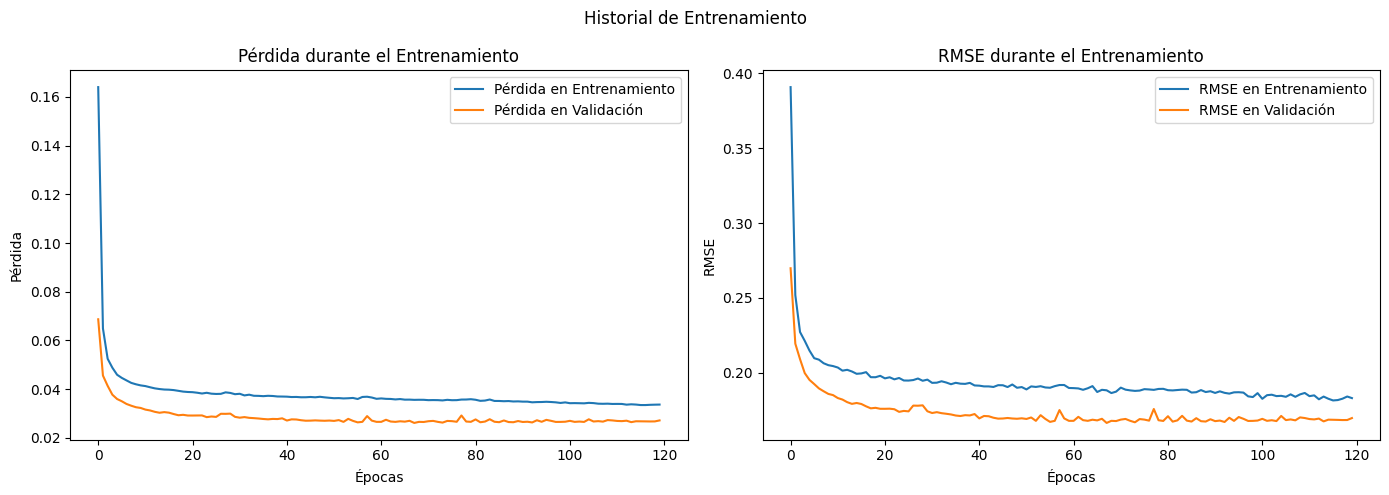

In [51]:
# Crear y entrenar el modelo SimpleRNN
model_simple_rnn = create_simple_rnn_model(input_shape, output_size, future_steps)
history_simple_rnn = model_simple_rnn.fit(X_train, y_train, epochs=120, batch_size=128, validation_data=(X_test, y_test), shuffle=True)
plot_training_history(history_simple_rnn)

In [52]:
# Evaluar los modelos en el conjunto de evaluación
loss_simple_rnn, rmse_simple_rnn = model_simple_rnn.evaluate(X_eval, y_eval)
print(f"SimpleRNN - Loss en el conjunto de evaluación: {loss_simple_rnn}")
print(f"SimpleRNN - RMSE en el conjunto de evaluación: {rmse_simple_rnn}")

3/3 [==============================] - 0s 7ms/step - loss: 0.0271 - rmse: 0.1614
SimpleRNN - Loss en el conjunto de evaluación: 0.0271468348801136
SimpleRNN - RMSE en el conjunto de evaluación: 0.1614246368408203


In [21]:
scalers

{'CO': MinMaxScaler(),
 'NO': MinMaxScaler(),
 'NO2': MinMaxScaler(),
 'NOX': MinMaxScaler(),
 'O3': MinMaxScaler(),
 'PM10': MinMaxScaler(),
 'PM25': MinMaxScaler(),
 'SO2': MinMaxScaler()}

3/3 [==============================] - 0s 5ms/step


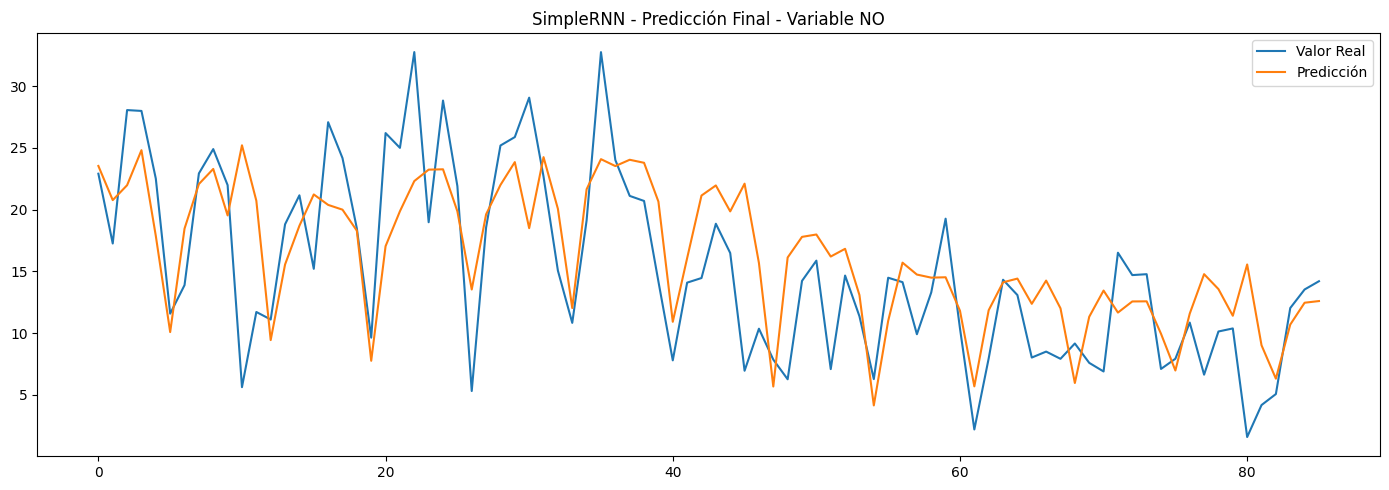

3/3 [==============================] - 0s 5ms/step


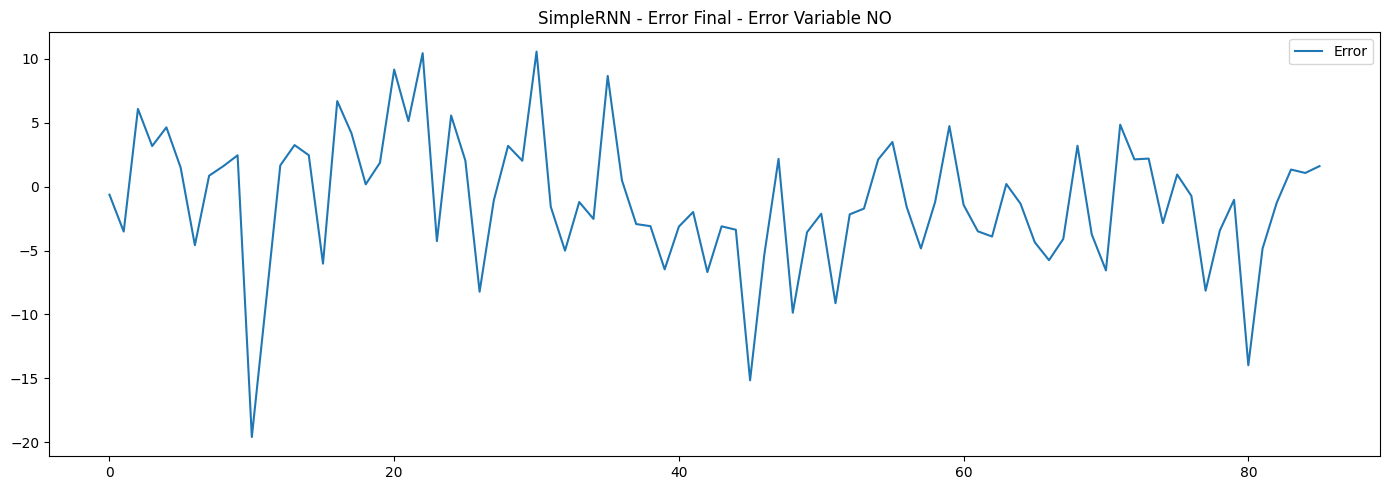

In [53]:
plot_final_prediction(model_simple_rnn, X_eval, y_eval, scalers, output_columns, future_steps, title='SimpleRNN - Predicción Final')
plot_final_errors(model_simple_rnn, X_eval, y_eval, scalers, output_columns, future_steps, title='SimpleRNN - Error Final')

1/1 [==============================] - 0s 21ms/step


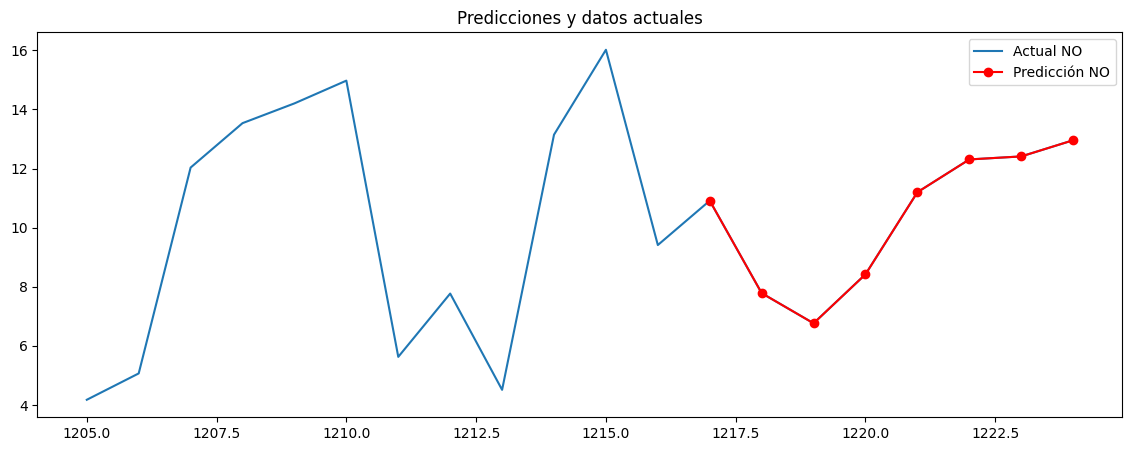

In [33]:
def add_predictions(model, data, input_columns, output_columns, time_steps, future_steps):
    """
    Añade múltiples predicciones al DataFrame de una sola vez.

    Args:
        model: Modelo entrenado.
        data (pd.DataFrame): DataFrame con los datos originales.
        input_columns (list of str): Lista de nombres de las columnas de entrada.
        output_columns (list of str): Lista de nombres de las columnas de salida.
        time_steps (int): Número de pasos de tiempo para las secuencias.
        future_steps (int): Número de pasos de tiempo futuros a predecir.

    Returns:
        pd.DataFrame: DataFrame con las predicciones añadidas.
    """
    # Escaladores
    scalers = {col: MinMaxScaler() for col in data.columns}

    # Escalar datos
    scaled_data = data.copy()
    for col in data.columns:
        scaled_data[col] = scalers[col].fit_transform(data[[col]])

    # Seleccionar la última secuencia de time_steps
    last_seq = scaled_data[input_columns].values[-time_steps:]
    last_seq = np.expand_dims(last_seq, axis=0)

    # Realizar la predicción
    predictions_scaled = model.predict(last_seq)

    # Reescalar las predicciones
    predictions = np.zeros((future_steps, len(output_columns)))
    for i, col in enumerate(output_columns):
        predictions[:, i] = scalers[col].inverse_transform(predictions_scaled[:, i::len(output_columns)].reshape(-1, 1)).reshape(-1)

    # Crear un DataFrame para las predicciones
    predictions_df = pd.DataFrame(predictions, columns=output_columns)

    # Añadir las predicciones al DataFrame original
    data_with_predictions = pd.concat([data, predictions_df], ignore_index=True)

    return data_with_predictions

def plot_with_predictions(data, output_columns, plot_steps, future_steps):
    """
    Visualiza los datos actuales y las predicciones.

    Args:
        data (pd.DataFrame): DataFrame con los datos actuales y las predicciones.
        output_columns (list of str): Lista de nombres de las columnas de salida.
        plot_steps (int): Número de pasos de tiempo a graficar antes de la predicción.
        future_steps (int): Número de pasos de tiempo futuros a predecir.
    """
    plt.figure(figsize=(14, 5))
    for col in output_columns:
        plt.plot(data.index[-(plot_steps + future_steps):], data[col].iloc[-(plot_steps + future_steps):], label=f'Actual {col}')
        plt.plot(data.index[-future_steps:], data[col].iloc[-future_steps:], 'ro-', label=f'Predicción {col}')

    plt.title('Predicciones y datos actuales')
    plt.legend()
    plt.show()
plot_steps = 12  # Número de pasos de tiempo a graficar antes de la predicción

# Añadir predicciones y visualizar
df_with_predictions = add_predictions(model_simple_rnn, df, input_columns, output_columns, time_steps, future_steps)
plot_with_predictions(df_with_predictions, output_columns, plot_steps, future_steps)

# modelo Multivariado multi-step


In [34]:
# Paso 1: Leer el archivo CSV
file_path = 'Datos_procesados.csv'  # Reemplaza con la ruta a tu archivo
df = pd.read_csv(file_path)

df_train, df_test, df_eval = split_dataframe(df, train_ratio=0.7, test_ratio=0.2)

print(f"Tamaño de datos de entrenamiento: {len(df_train)}")
print(f"Tamaño de datos de prueba: {len(df_test)}")
print(f"Tamaño de datos de evaluación: {len(df_eval)}")

Tamaño de datos de entrenamiento: 851
Tamaño de datos de prueba: 243
Tamaño de datos de evaluación: 123


In [40]:
scaled_train_df, scaled_test_df, scaled_eval_df, scalers = scale_datasets(df_train, df_test, df_eval)

time_steps = 24
future_steps = 8
input_columns = ['NO','CO','PM10','O3']  # Nombres de las columnas de entrada en el DataFrame escalado
#input_columns = ['NO']  # Nombres de las columnas de entrada en el DataFrame escalado
output_columns = ['NO']  # Nombres de las columnas de salida en el DataFrame escalado


X_train, y_train = create_sequences(scaled_train_df, input_columns, output_columns, time_steps, future_steps)
X_test, y_test = create_sequences(scaled_test_df, input_columns, output_columns, time_steps, future_steps)
X_eval, y_eval = create_sequences(scaled_eval_df, input_columns, output_columns, time_steps, future_steps)

print(f"Tamaño de X_train: {X_train.shape}")
print(f"Tamaño de y_train: {y_train.shape}")
print(f"Tamaño de X_test: {X_test.shape}")
print(f"Tamaño de y_test: {y_test.shape}")
print(f"Tamaño de X_eval: {X_eval.shape}")
print(f"Tamaño de y_eval: {y_eval.shape}")

input_shape = (X_train.shape[1], X_train.shape[2])
output_size = len(output_columns)

Tamaño de X_train: (820, 24, 4)
Tamaño de y_train: (820, 8)
Tamaño de X_test: (212, 24, 4)
Tamaño de y_test: (212, 8)
Tamaño de X_eval: (92, 24, 4)
Tamaño de y_eval: (92, 8)


Epoch 1/120
7/7 [==============================] - 2s 58ms/step - loss: 0.1958 - rmse: 0.4342 - val_loss: 0.1009 - val_rmse: 0.3273
Epoch 2/120
7/7 [==============================] - 0s 14ms/step - loss: 0.0906 - rmse: 0.2951 - val_loss: 0.0511 - val_rmse: 0.2330
Epoch 3/120
7/7 [==============================] - 0s 12ms/step - loss: 0.0538 - rmse: 0.2309 - val_loss: 0.0397 - val_rmse: 0.2052
Epoch 4/120
7/7 [==============================] - 0s 14ms/step - loss: 0.0473 - rmse: 0.2182 - val_loss: 0.0380 - val_rmse: 0.2008
Epoch 5/120
7/7 [==============================] - 0s 13ms/step - loss: 0.0456 - rmse: 0.2141 - val_loss: 0.0351 - val_rmse: 0.1930
Epoch 6/120
7/7 [==============================] - 0s 11ms/step - loss: 0.0449 - rmse: 0.2112 - val_loss: 0.0348 - val_rmse: 0.1918
Epoch 7/120
7/7 [==============================] - 0s 15ms/step - loss: 0.0448 - rmse: 0.2111 - val_loss: 0.0349 - val_rmse: 0.1925
Epoch 8/120
7/7 [==============================] - 0s 14ms/step - loss: 0.04

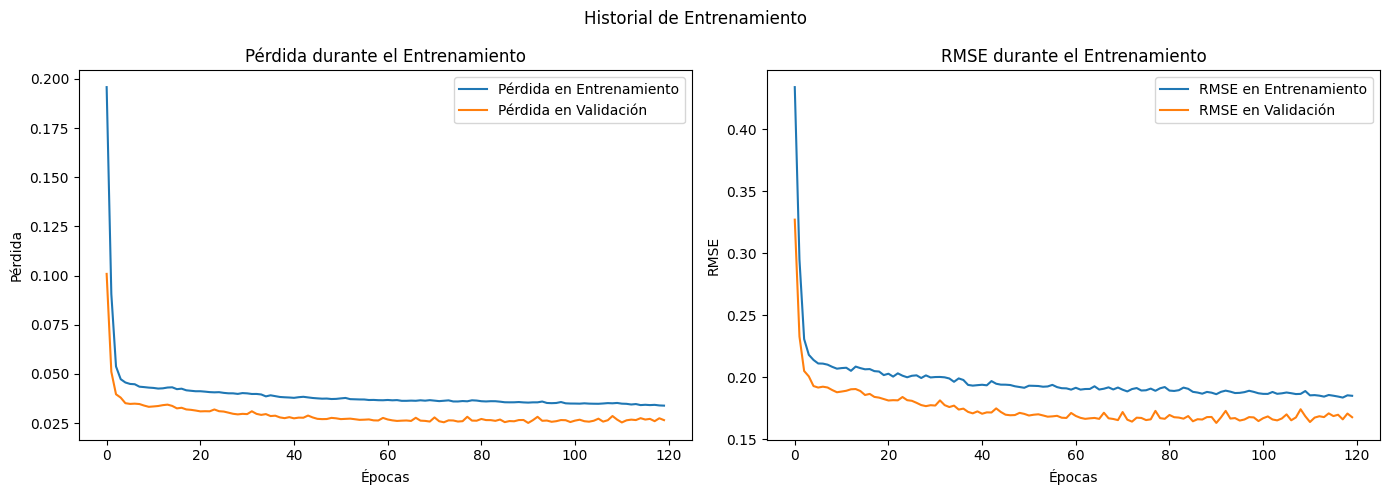

In [54]:
# Crear y entrenar el modelo SimpleRNN
model_simple_rnn = create_simple_rnn_model(input_shape, output_size, future_steps)
history_simple_rnn = model_simple_rnn.fit(X_train, y_train, epochs=120, batch_size=128, validation_data=(X_test, y_test), shuffle=True)
plot_training_history(history_simple_rnn)

In [55]:
# Evaluar los modelos en el conjunto de evaluación
loss_simple_rnn, rmse_simple_rnn = model_simple_rnn.evaluate(X_eval, y_eval)
print(f"SimpleRNN - Loss en el conjunto de evaluación: {loss_simple_rnn}")
print(f"SimpleRNN - RMSE en el conjunto de evaluación: {rmse_simple_rnn}")

3/3 [==============================] - 0s 9ms/step - loss: 0.0279 - rmse: 0.1618
SimpleRNN - Loss en el conjunto de evaluación: 0.027877317741513252
SimpleRNN - RMSE en el conjunto de evaluación: 0.16179680824279785


3/3 [==============================] - 0s 4ms/step


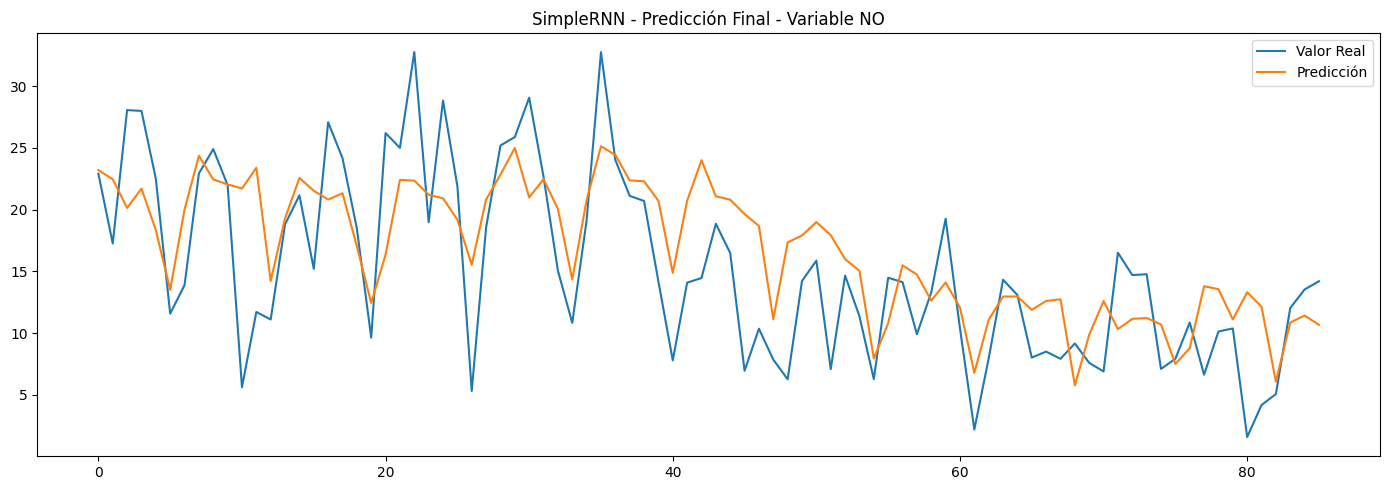

3/3 [==============================] - 0s 6ms/step


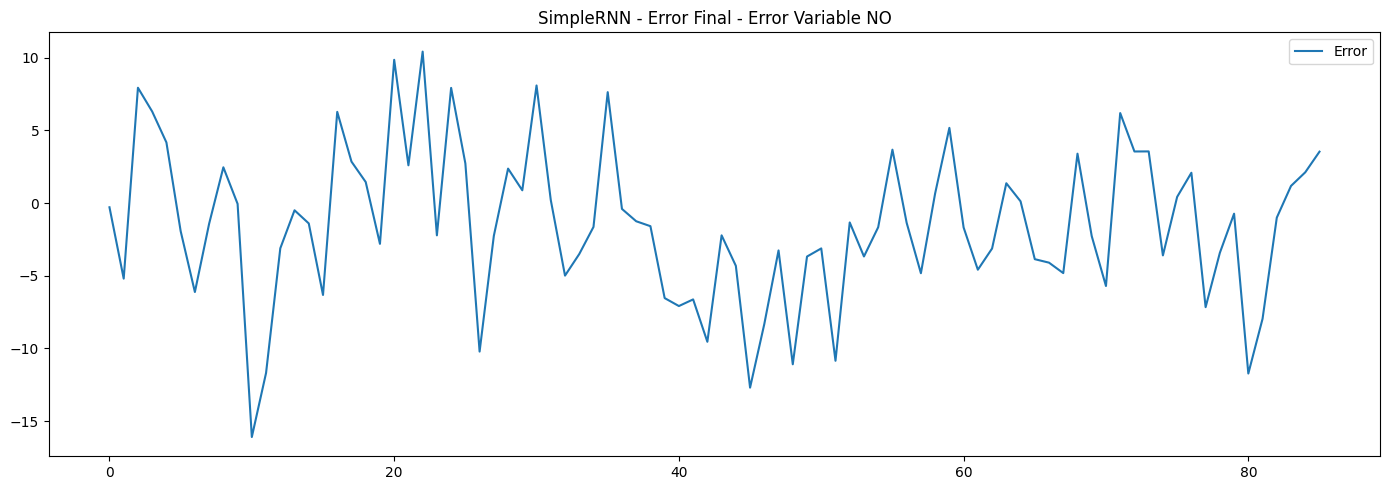

In [56]:
# PREDICCIONES
plot_final_prediction(model_simple_rnn, X_eval, y_eval, scalers, output_columns, future_steps, title='SimpleRNN - Predicción Final')
plot_final_errors(model_simple_rnn, X_eval, y_eval, scalers, output_columns, future_steps, title='SimpleRNN - Error Final')

1/1 [==============================] - 0s 19ms/step


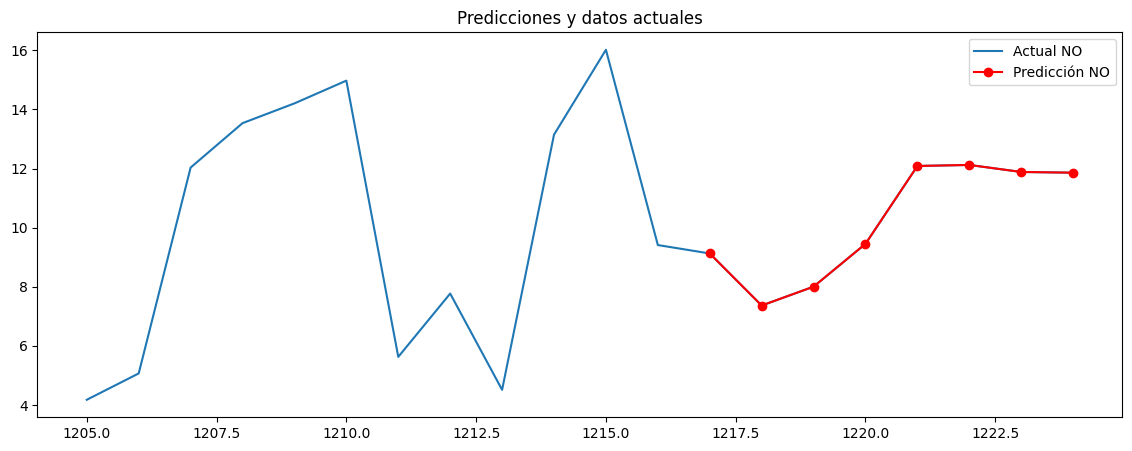

In [57]:
def add_predictions(model, data, input_columns, output_columns, time_steps, future_steps):
    """
    Añade múltiples predicciones al DataFrame de una sola vez.

    Args:
        model: Modelo entrenado.
        data (pd.DataFrame): DataFrame con los datos originales.
        input_columns (list of str): Lista de nombres de las columnas de entrada.
        output_columns (list of str): Lista de nombres de las columnas de salida.
        time_steps (int): Número de pasos de tiempo para las secuencias.
        future_steps (int): Número de pasos de tiempo futuros a predecir.

    Returns:
        pd.DataFrame: DataFrame con las predicciones añadidas.
    """
    # Escaladores
    scalers = {col: MinMaxScaler() for col in data.columns}

    # Escalar datos
    scaled_data = data.copy()
    for col in data.columns:
        scaled_data[col] = scalers[col].fit_transform(data[[col]])

    # Seleccionar la última secuencia de time_steps
    last_seq = scaled_data[input_columns].values[-time_steps:]
    last_seq = np.expand_dims(last_seq, axis=0)

    # Realizar la predicción
    predictions_scaled = model.predict(last_seq)

    # Reescalar las predicciones
    predictions = np.zeros((future_steps, len(output_columns)))
    for i, col in enumerate(output_columns):
        predictions[:, i] = scalers[col].inverse_transform(predictions_scaled[:, i::len(output_columns)].reshape(-1, 1)).reshape(-1)

    # Crear un DataFrame para las predicciones
    predictions_df = pd.DataFrame(predictions, columns=output_columns)

    # Añadir las predicciones al DataFrame original
    data_with_predictions = pd.concat([data, predictions_df], ignore_index=True)

    return data_with_predictions

def plot_with_predictions(data, output_columns, plot_steps, future_steps):
    """
    Visualiza los datos actuales y las predicciones.

    Args:
        data (pd.DataFrame): DataFrame con los datos actuales y las predicciones.
        output_columns (list of str): Lista de nombres de las columnas de salida.
        plot_steps (int): Número de pasos de tiempo a graficar antes de la predicción.
        future_steps (int): Número de pasos de tiempo futuros a predecir.
    """
    plt.figure(figsize=(14, 5))
    for col in output_columns:
        plt.plot(data.index[-(plot_steps + future_steps):], data[col].iloc[-(plot_steps + future_steps):], label=f'Actual {col}')
        plt.plot(data.index[-future_steps:], data[col].iloc[-future_steps:], 'ro-', label=f'Predicción {col}')

    plt.title('Predicciones y datos actuales')
    plt.legend()
    plt.show()
plot_steps = 12  # Número de pasos de tiempo a graficar antes de la predicción

# Añadir predicciones y visualizar
df_with_predictions = add_predictions(model_simple_rnn, df, input_columns, output_columns, time_steps, future_steps)
plot_with_predictions(df_with_predictions, output_columns, plot_steps, future_steps)